# Aufgabe 1 - Akku-Abenteuer: Tobi's Optimale Routenplanung

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird. 

## Teilaufgabe a): lageplan.png laden und verarbeiten

In [1]:
from PIL import Image, ImageDraw
import numpy as np

def rgb_to_label(pixel):
    color_map = {
        (0, 0, 0): "Wall",
        (255, 255, 255): "Outside",
        (200, 113, 55): "Hallway",
        (0, 0, 255): "Teakitchen",
        (0, 255, 0): "Professor",
        (255, 255, 0): "Laboratory",
        (255, 0, 0): "Red line"
    }
    return color_map.get(pixel, "Unknown")

def png_to_numpy_array(file_path, grid_size=21, red_line_width=1):
    img = Image.open(file_path).convert("RGB")
    width, height = img.size

    cell_width = (width - (grid_size - 1) * red_line_width) // grid_size
    cell_height = (height - (grid_size - 1) * red_line_width) // grid_size

    numpy_array = np.empty((grid_size, grid_size), dtype=object)

    for i in range(grid_size):
        for j in range(grid_size):
            y = i * (cell_height + red_line_width) + cell_height // 2
            x = j * (cell_width + red_line_width) + cell_width // 2

            pixel = img.getpixel((x, y))
            label = rgb_to_label(pixel)
            numpy_array[i][j] = label

    return numpy_array

# Replace 'input_image.png' with the path to your image file
file_path = 'lageplan.png'
map_layout = png_to_numpy_array(file_path)


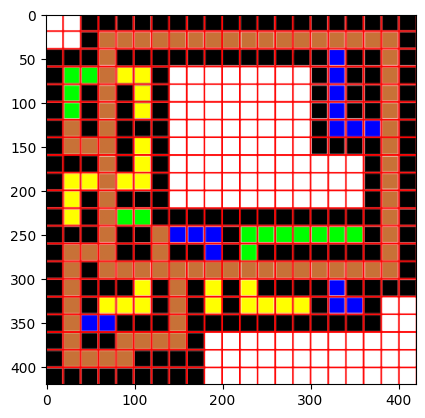

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(file_path)
imgplot = plt.imshow(img)
plt.show()

In [3]:
def visualize_path(numpy_array, path, title):
    # Load the original image
    img = Image.open(file_path)

    # Create a transparent overlay
    overlay = Image.new("RGBA", img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)

    # Determine the size of each cell
    cell_width = img.width // numpy_array.shape[1]
    cell_height = img.height // numpy_array.shape[0]

    offset = 5

    # Draw the path on the overlay
    for y, x in path:
        draw.rectangle([(x * cell_width + offset, y * cell_height + offset),
                        (x * cell_width + cell_width - offset, y * cell_height + cell_height- offset)],
                       fill=(0, 0, 0, 235))

    # Combine the original image with the overlay
    result = Image.alpha_composite(img.convert("RGBA"), overlay)

    result.save("outputs/" + title + ".png")

    # Display the result
    result.show()

## Teilaufgabe b): Breitensuche

In [4]:
from collections import deque

def is_valid_move(x, y, visited, numpy_array):
    valid_labels = {"Hallway", "Teakitchen", "Professor", "Laboratory"}
    return (0 <= x < len(numpy_array) and
            0 <= y < len(numpy_array[0]) and
            numpy_array[x][y] in valid_labels and
            not visited[x][y])

def bfs_path(start, end, numpy_array):
    queue = deque()
    queue.append((start, []))
    visited = np.zeros_like(numpy_array, dtype=bool)

    while queue:
        (x, y), path = queue.popleft()
        visited[x][y] = True

        if (x, y) == end:
            return path + [(x, y)]

        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if is_valid_move(nx, ny, visited, numpy_array):
                queue.append(((nx, ny), path + [(x, y)]))
                visited[nx][ny] = True

    return None

start = (17, 3)
end = (3, 1)
path = bfs_path(start, end, map_layout)

if path:
    print("Path found:", path)
else:
    print("No path found")

Path found: [(17, 3), (16, 3), (16, 4), (16, 5), (15, 5), (14, 5), (14, 4), (14, 3), (13, 3), (12, 3), (11, 3), (10, 3), (9, 3), (8, 3), (7, 3), (6, 3), (5, 3), (4, 3), (3, 3), (3, 2), (3, 1)]


## Teilaufgabe c): A*-Algorithmus

In [5]:
import heapq
import math

def cost(label, x, y, spilled):
    cost_map = {
        "Hallway": 2,
        "Teakitchen": 3,
        "Professors room": 4,
        "Laboratory": 5
    }
    if spilled and 14 >= y >= 3 == x:
        return 20
    else:
        return cost_map.get(label, float('inf'))

def heuristic(y1, x1, y2, x2):
    return math.sqrt((y1 - y2) ** 2 + (x1 - x2) ** 2)

def a_star_path(start, end, numpy_array, spilled):
    visited = np.zeros_like(numpy_array, dtype=bool)
    pq = [(0, 0, start, [])]  # priority, cost, position, path

    while pq:
        priority, current_cost, (y, x), path = heapq.heappop(pq)
        visited[y][x] = True

        if (y, x) == end:
            return path + [(y, x)]

        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ny, nx = y + dy, x + dx
            if is_valid_move(ny, nx, visited, numpy_array):
                new_cost = current_cost + cost(numpy_array[ny][nx], nx, ny, spilled)
                new_priority = new_cost + heuristic(ny, nx, end[0], end[1])
                heapq.heappush(pq, (new_priority, new_cost, (ny, nx), path + [(y, x)]))
                visited[ny][nx] = True

    return None

path = a_star_path(start, end, map_layout, False)

if path:
    print("Path found:", path)
else:
    print("No path found")

Path found: [(17, 3), (17, 2), (17, 1), (16, 1), (15, 1), (14, 1), (13, 1), (13, 2), (13, 3), (12, 3), (11, 3), (10, 3), (9, 3), (8, 3), (7, 3), (6, 3), (5, 3), (4, 3), (3, 3), (3, 2), (3, 1)]


## Teilaufgabe d): Greedy Best First Search-Algorithmus

In [6]:
def greedy_best_first_search_path(start, end, numpy_array):
    visited = np.zeros_like(numpy_array, dtype=bool)
    pq = [(0, start, [])]  # priority, position, path

    while pq:
        priority, (y, x), path = heapq.heappop(pq)
        visited[y][x] = True

        if (y, x) == end:
            return path + [(y, x)]

        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ny, nx = y + dy, x + dx
            if is_valid_move(ny, nx, visited, numpy_array):
                new_priority = heuristic(ny, nx, end[0], end[1])
                heapq.heappush(pq, (new_priority, (ny, nx), path + [(y, x)]))
                visited[ny][nx] = True

    return None

path = greedy_best_first_search_path(start, end, map_layout)

if path:
    print("Path found:", path)
else:
    print("No path found")

Path found: [(17, 3), (16, 3), (16, 4), (16, 5), (15, 5), (14, 5), (14, 4), (14, 3), (13, 3), (12, 3), (11, 3), (10, 3), (9, 3), (8, 3), (7, 3), (6, 3), (5, 3), (4, 3), (3, 3), (3, 2), (3, 1)]


## Teilaufgabe e): Dusseliger Doktorand

In [7]:
b_path = bfs_path(start, end, map_layout)
if b_path:
    visualize_path(map_layout, b_path, "BFS Search")
else:
    print("No BFS path found")

a_path_coffee = a_star_path(start, end, map_layout, False)
if a_path_coffee:
    visualize_path(map_layout, a_path_coffee, "A* Search no coffee spill")
else:
    print("No A* path found")

a_path_coffee = a_star_path(start, end, map_layout, True)
if a_path_coffee:
    visualize_path(map_layout, a_path_coffee, "A* Search with coffee spill")
else:
    print("No A* path found")

g_path = greedy_best_first_search_path(start, end, map_layout)
if g_path:
    visualize_path(map_layout, g_path, "Greedy Best First Search")
else:
    print("No Greedy Best First Search path found")